In [39]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [40]:
from dask_jobqueue import PBSCluster
# for heavy processing:
#cluster = PBSCluster(cores=6, processes=6, walltime='06:00:00')
#w = cluster.scale(6*10)

cluster = PBSCluster(cores=6, processes=6,  walltime='06:00:00')
w = cluster.scale(2*10)
#w = cluster.scale(12*10) # for part 1 rspectra estimates

In [41]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [42]:
client

Client Scheduler: tcp://10.135.39.22:40225 Dashboard: http://10.135.39.22:8787/status,Cluster Workers: 24 Cores: 24 Memory: 400.08 GB


________________________
# 1. Rotary spectral for SSH

In [13]:
# no need to store Eta first
# cluster = PBSCluster(cores=6, processes=6,  walltime='06:00:00')
# w = cluster.scale(12*10)
dij=4
time_length = 8640

# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = work_data_dir+'xy/SSH/E_ssh_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        ds = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('Eta')).isel(time=slice(1512,1512+time_length),face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        del ds['Eta'].encoding['chunks']
        del ds['time'].encoding['chunks']
        #dsE = dsE.chunk({'time':time_length, 'i': 24*8, 'j':47*4})    
        
        # store
        for c in ds.coords:
            try:
                del ds[c].encoding['chunks']
            except:
                print(c)

        ds = ds.chunk({'time':1440, 'i': 24*8, 'j':47*4}) 
        
        ds['eta'] = ds['Eta'].fillna(0.) 
        
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E(ds['eta'].isel(i=2,j=2))
        #
        E = get_E(ds['eta'].fillna(0.), f=f)        

        # store
        E = E.to_dataset()
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})

        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 38.4 s, sys: 3.36 s, total: 41.7 s
Wall time: 1min 40s
--- face 0 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 47.1 s, sys: 4.18 s, total: 51.3 s
Wall time: 2min 12s
--- face 1 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 41.8 s, sys: 3.94 s, total: 45.7 s
Wall time: 1min 50s
--- face 2 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 35.9 s, sys: 2.67 s, total: 38.6 s
Wall time: 1min 33s
--- face 3 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 49.1 s, sys: 4.49 s, total: 53.6 s
Wall time: 2min 18s
--- face 4 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 30.3 s, sys: 1.96 s, total: 32.3 s
Wall time: 1min 26s
--- face 5 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 46.5 s, sys: 3.97 s, total: 50.5 s
Wall time: 2min 7s
--- face 6 done
time
dataset size: 80.6 GB
face
i
j
freq_time
CPU times: user 46 s, sy

___________
# 2. Band

In [6]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


In [24]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#face_all = [1]


for face in face_all:
    
    ds = xr.open_zarr(work_data_dir+'xy/SSH/E_ssh_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)  
    E = ds.eta
    #E = E.assign_coords(freq_cps=E.freq_time / 86400.) 
    df=E.freq_time[1]-E.freq_time[0]

    # total KE
    E_all = (E*df).sum(dim='freq_time')
    E_all = E_all.chunk({'i': 1080, 'j': 1080}) 
    E_all = np.real(E_all).rename('E_all')

    # high-frequency KE (<0.5 day)
    E_high = (E.where(abs(E.freq_time)>0.5, other=0.)*df).sum(dim='freq_time')
    E_high = E_high.chunk({'i': 1080, 'j': 1080}) 
    E_high = np.real(E_high).rename('E_high')

    # semi-diurnal
    E_semi = (E.where((abs(E.freq_time)>1.9) & (abs(E.freq_time)<2.1), other=0.)*df).sum(dim='freq_time')
    E_semi = E_semi.chunk({'i': 1080, 'j': 1080}) 
    E_semi = np.real(E_semi).rename('E_semi')

    # diurnal
    E_diurnal = (E.where((abs(E.freq_time)>0.9) & (abs(E.freq_time)<1.1), other=0.)*df).sum(dim='freq_time')
    E_diurnal = E_diurnal.chunk({'i': 1080, 'j': 1080}) 
    E_diurnal = np.real(E_diurnal).rename('E_diurnal')

    # low-frequency KE (>0.5 day)    
    E_low = E_all - E_high
    E_low = E_low.chunk({'i': 1080, 'j': 1080}) 
    E_low = np.real(E_low).rename('E_low')

    # merge together
    E_band = xr.merge([E_high, E_semi, E_diurnal, E_all, E_low])
    file_E = work_data_dir+'xy/SSH/E_band_integral_f%02d.zarr'%face
    %time E_band.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

CPU times: user 2.57 s, sys: 194 ms, total: 2.76 s
Wall time: 9.18 s
face 0 done
CPU times: user 2.64 s, sys: 223 ms, total: 2.86 s
Wall time: 8.69 s
face 1 done
CPU times: user 2.48 s, sys: 200 ms, total: 2.68 s
Wall time: 7.46 s
face 2 done
CPU times: user 2.58 s, sys: 181 ms, total: 2.76 s
Wall time: 7.19 s
face 3 done
CPU times: user 2.69 s, sys: 245 ms, total: 2.93 s
Wall time: 9.49 s
face 4 done
CPU times: user 2.54 s, sys: 180 ms, total: 2.72 s
Wall time: 8.41 s
face 5 done
CPU times: user 2.71 s, sys: 226 ms, total: 2.94 s
Wall time: 9.54 s
face 6 done
CPU times: user 2.52 s, sys: 207 ms, total: 2.73 s
Wall time: 8.05 s
face 7 done
CPU times: user 2.63 s, sys: 247 ms, total: 2.88 s
Wall time: 7.92 s
face 8 done
CPU times: user 2.43 s, sys: 235 ms, total: 2.66 s
Wall time: 7.55 s
face 9 done
CPU times: user 2.7 s, sys: 216 ms, total: 2.91 s
Wall time: 8.37 s
face 10 done
CPU times: user 2.42 s, sys: 215 ms, total: 2.63 s
Wall time: 7.64 s
face 11 done
CPU times: user 2.61 s, sys

In [7]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/SSH/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds = xr.concat(D, dim='face')
ds = ds.assign_coords(Depth=grd_rspec.Depth) 
ds = ds.assign_coords(XC=grd_rspec.XC) 
ds = ds.assign_coords(YC=grd_rspec.YC) 
E = ds.E_all
E_low = ds.E_low
E_high = ds.E_high
E_semi = ds.E_semi
E_diurnal = ds.E_diurnal
E

<xarray.DataArray 'E_all' (face: 13, j: 1080, i: 1080)>
dask.array<concatenate, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [25]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            if face in [11,12]:
                # this deals with dateline crossing areas
                im = vplt.where(vplt.j!=40).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[-3, -2, -1, 0])
        cb.ax.set_yticklabels(['10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

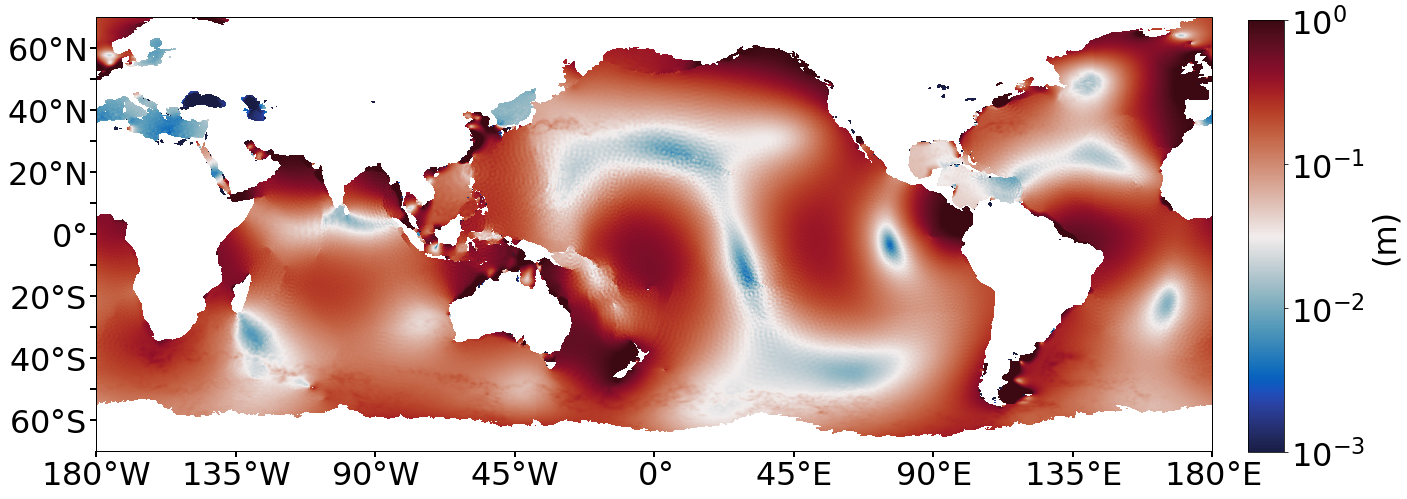

In [26]:
plot_pretty( np.log10( E.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='(m)', vmin=-3, vmax=0, cmmap='balance', ignore_face=[6])

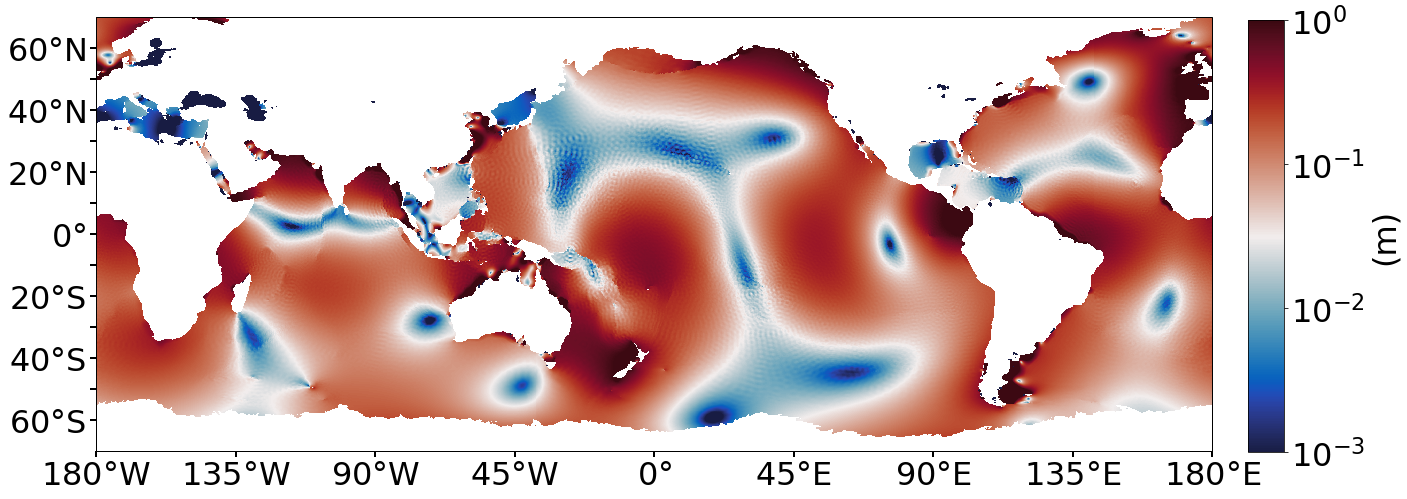

In [27]:
plot_pretty( np.log10( E_semi.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='(m)', vmin=-3, vmax=0, cmmap='balance', ignore_face=[6])

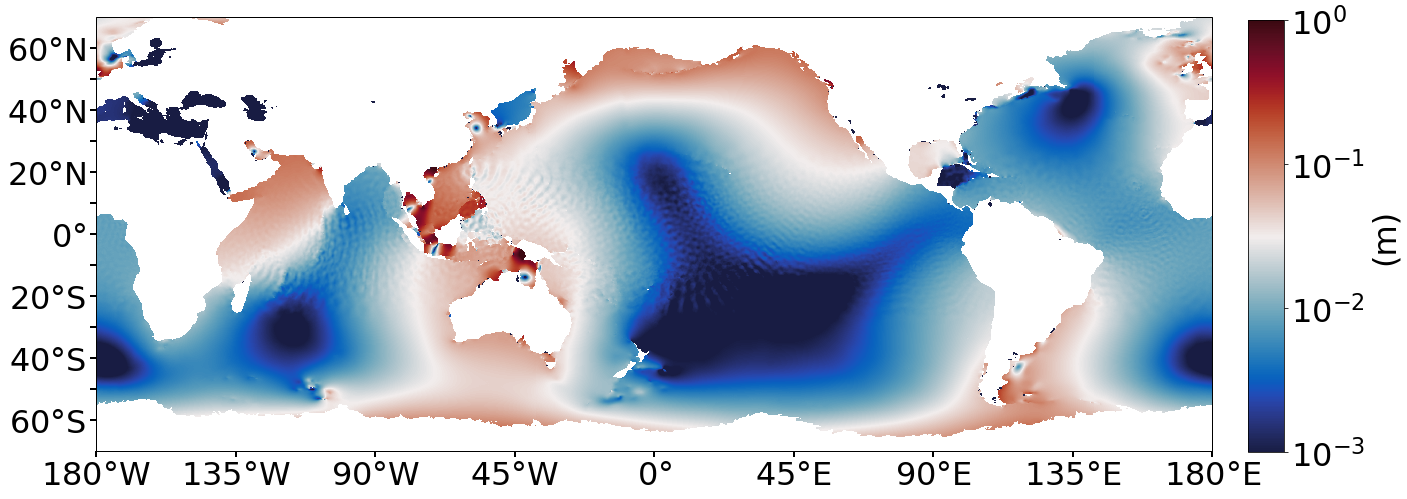

In [28]:
plot_pretty( np.log10( E_diurnal.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='(m)', vmin=-3, vmax=0, cmmap='balance', ignore_face=[6])

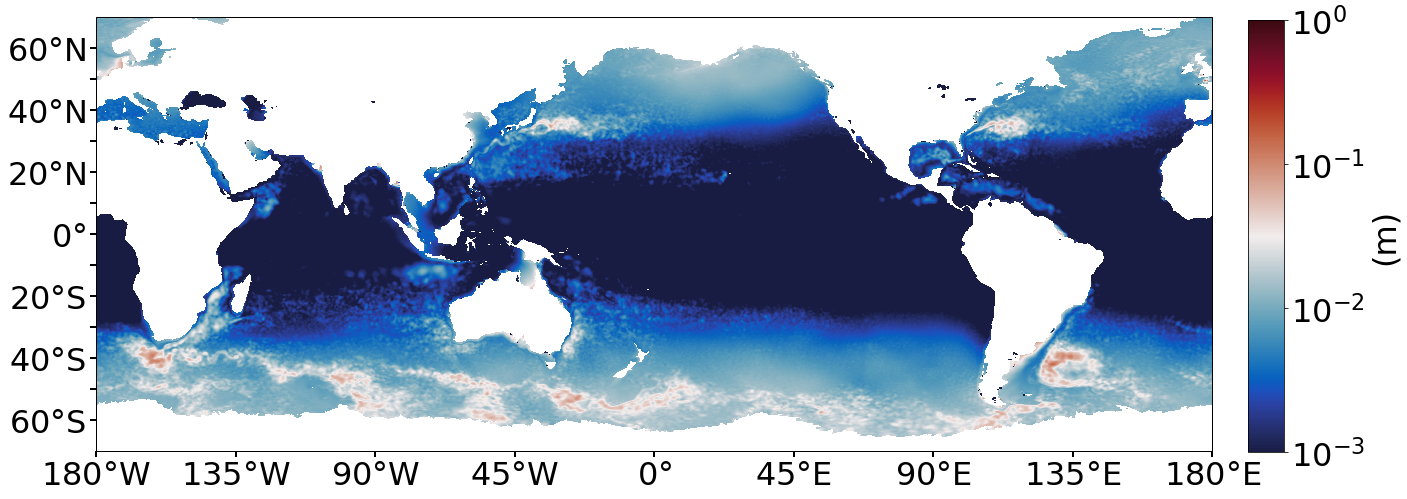

In [29]:
plot_pretty( np.log10( E_low.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='(m)', vmin=-3, vmax=0, cmmap='balance', ignore_face=[6])

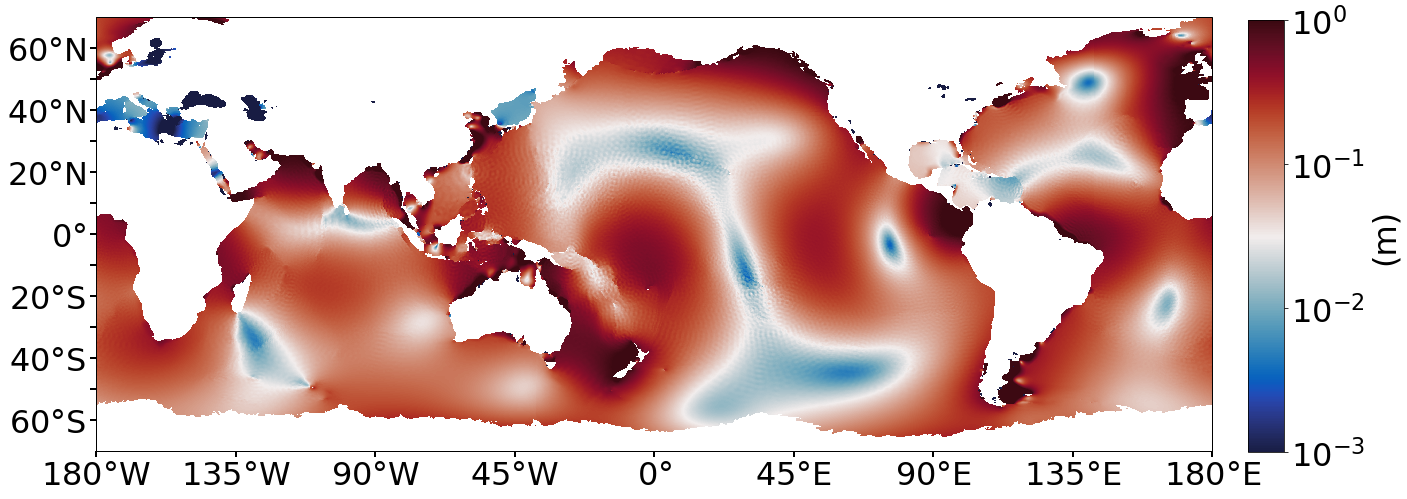

In [30]:
plot_pretty( np.log10( E_high.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='(m)', vmin=-3, vmax=0, cmmap='balance', ignore_face=[6])

_______________
# 3. Zonal average

In [15]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [20]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


In [35]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/SSH/E_ssh_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
ds = ds.assign_coords(Depth=grd_rspec.Depth) 
ds = ds.assign_coords(XC=grd_rspec.XC) 
ds = ds.assign_coords(YC=grd_rspec.YC) 
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    eta        (face, j, i, freq_time) float64 dask.array<chunksize=(1, 188, 192, 1440), meta=np.ndarray>


In [24]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    E = lds.eta.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False).where(lice>0) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/SSH/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done
--- face 3 done
--- face 4 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


--- face 5 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


--- face 6 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


--- face 7 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


--- face 8 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


--- face 9 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


--- face 10 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


--- face 12 done


In [36]:
F = [11]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    E = lds.eta.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False).where(lice>0)  # filter out shallow depths
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/SSH/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 2 done


In [52]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'ssh'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/SSH/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ssh_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ssh_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98


Text(0.5, 0, 'Frequency (cpd)')

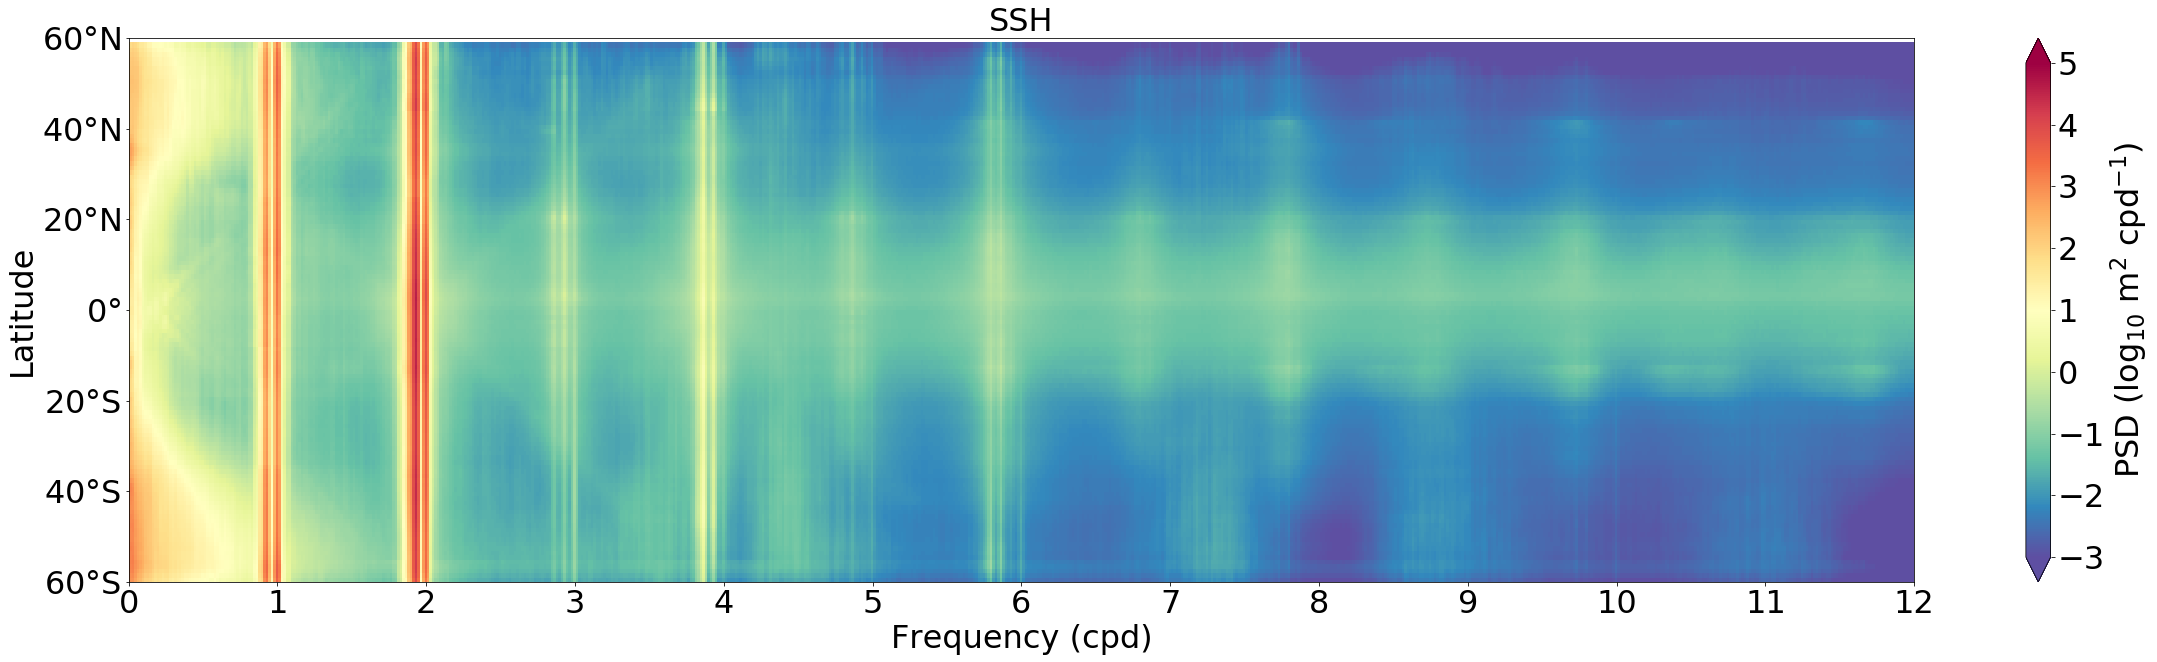

In [53]:
font_size = 32
fig, ax = plt.subplots(figsize=(40, 10))

cax=np.log10(E_ssh_zav*86400/6).plot(vmin=-3, vmax=5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ m$^2$ cpd$^{-1}$)', fontsize=font_size)
#ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(0., 12.)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_title('SSH',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)


____________
# 4. Gloabl mean

In [43]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


In [44]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/SSH/E_ssh_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
ds = ds.assign_coords(Depth=grd_rspec.Depth) 
ds = ds.assign_coords(XC=grd_rspec.XC) 
ds = ds.assign_coords(YC=grd_rspec.YC) 
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    eta        (face, j, i, freq_time) float64 dask.array<chunksize=(1, 188, 192, 1440), meta=np.ndarray>


In [45]:
E_mean = (ds.eta.isel(i=slice(1,-1),j=slice(1,-1)).where( (ds.YC>10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))

E_mean_2 = (ds.eta.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))
E_mean_2 = E_mean_2.assign_coords(freq_time=E_mean_2.freq_time * -1.) 

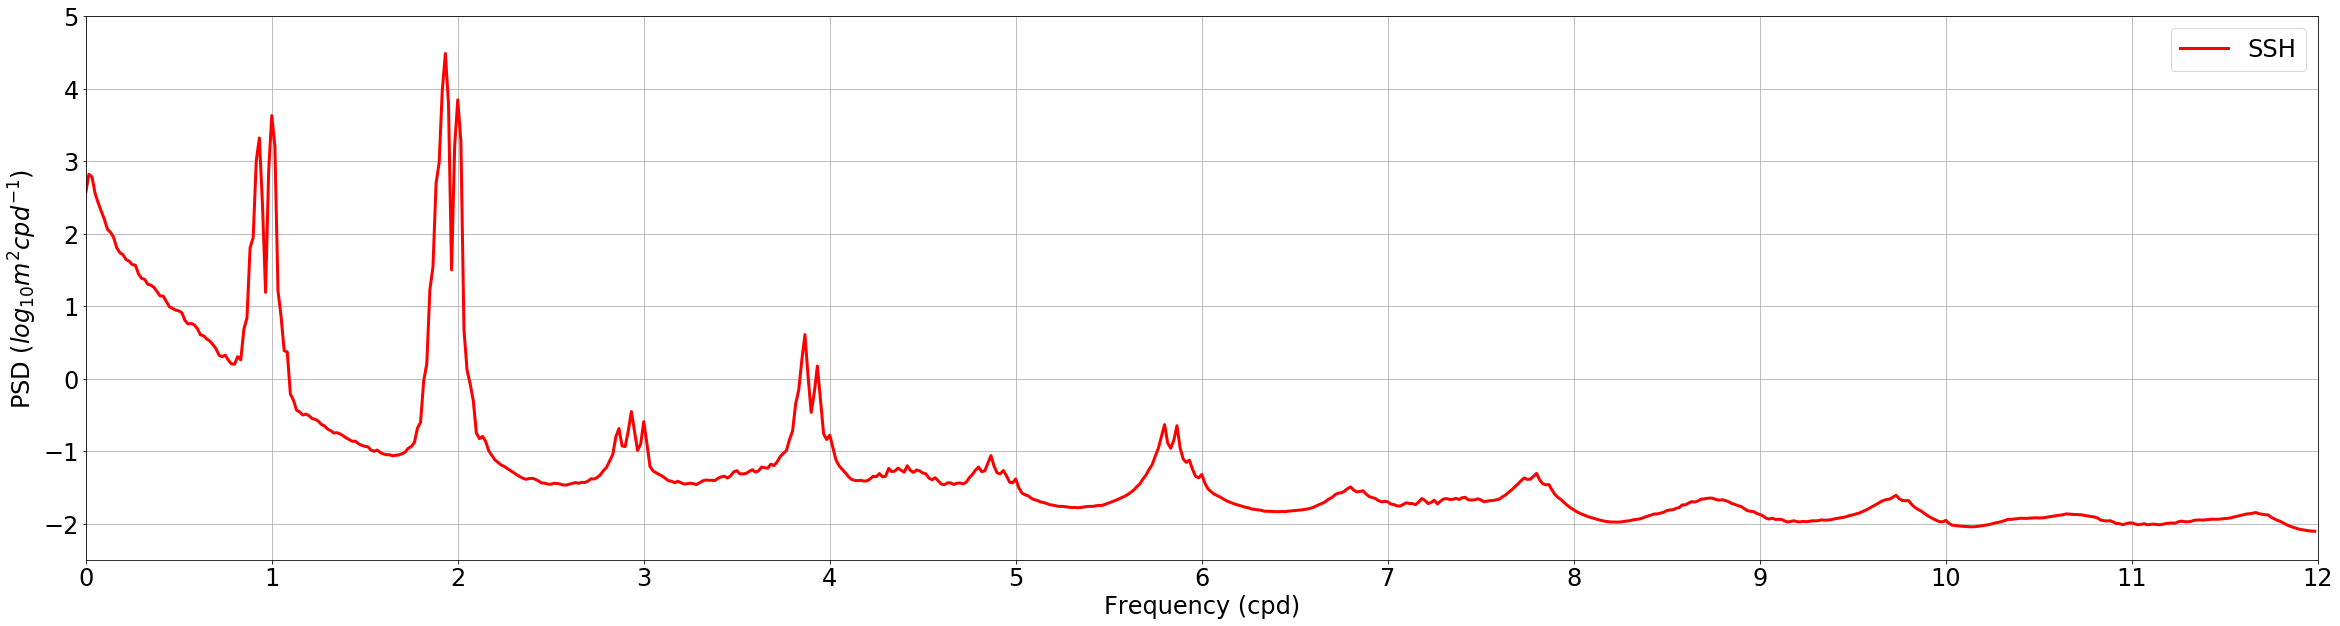

In [51]:
fig, ax = plt.subplots(figsize=(40,10))

labels = ['SSH']
(np.log10((E_mean_2+E_mean)*86400/2/6)).plot(ax=ax,color='red', label=labels[0],linewidth=3)
ax.grid()
ax.legend()
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylim([-2.5,5])
#ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10} m^2 cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

In [54]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=